# 5 - 批量规范化
## 5.1 从零实现
- 在模型训练过程中，批量规范化利用小批量的均值和标准差，不断调整神经网络的中间输出，使整个神经网络各层的中间输出值更加稳定。
- 批量规范化在全连接层和卷积层的使用略有不同。
- 批量规范化层和暂退层一样，在训练模式和预测模式下计算不同。
- 批量规范化有许多有益的副作用，主要是正则化。另一方面，”减少内部协变量偏移“的原始动机似乎不是一个有效的解释。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim = 0)
            var = ((X - mean) ** 2).mean(dim = 0)
        else :
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差
            # 这里我们需要保持X的形状以便以后可以做广播运算
            mean = X.mean(dim = (0, 2, 3), keepdim = True)
            var = ((X - mean) ** 2).mean(dim = (0, 2, 3), keepdim = True)
        # 训练模式下，用当前均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        #更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta # 缩放和位移
    return Y, moving_mean.data, moving_var.data

In [2]:
class BatchNorm(nn.Module):
    # num_features: 完全连接层的输出数量或卷积层的输出通道数
    # num_dims: 2表示完全连接层， 4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else :
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化为1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    
    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var 复制到X所在的显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps = 1e-5,
            momentum = 0.9)
        return Y

## 5.2 使用批量规范化层的LeNet

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size = 5), BatchNorm(6, num_dims = 4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(6, 16, kernel_size = 5), BatchNorm(16, num_dims = 4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size = 2, stride = 2), nn.Flatten(),
    nn.Linear(256, 120), BatchNorm(120, num_dims = 2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims = 2), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.262, train acc 0.903, test acc 0.845
19976.4 examples/sec on cuda:0


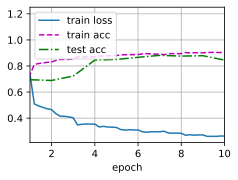

In [4]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_iter.num_workers = 0
test_iter.num_workers = 0
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
plt.show()

In [5]:
net[1].gamma.reshape((-1, )), net[1].beta.reshape((-1, ))

(tensor([3.8086, 2.9692, 2.8914, 2.4068, 2.5875, 3.5016], device='cuda:0',
        grad_fn=<ViewBackward>),
 tensor([-1.9273, -1.9261, -2.2096,  1.2588, -1.9862,  3.4762], device='cuda:0',
        grad_fn=<ViewBackward>))

## 5.3 - 简明实现

In [6]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size = 5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    nn.Conv2d(6, 16, kernel_size = 5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size = 2, stride = 2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss 0.262, train acc 0.904, test acc 0.843
35116.8 examples/sec on cuda:0


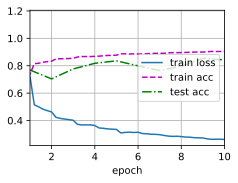

In [7]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
plt.show()